In [33]:
import os
import sep
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from iminuit import Minuit
from astropy.io import fits
from astropy.visualization import ImageNormalize, ZScaleInterval, LogStretch

In [34]:
plt.rcParams['figure.figsize'] = (12, 8)

In [45]:
YEAR = 11
NIGHT = 66
DARK_DIR = '/project/projectdirs/snfactry/SNIFS_from_deepsky/overscanned/{:02d}/{:03d}/'.format(YEAR, NIGHT)

def plot_img(data_or_path):
    if type(data_or_path) is str:
        data = fits.getdata(data_or_path)
    else:
        data = data_or_path
    norm = ImageNormalize(data, ZScaleInterval())
    plt.imshow(data.T, norm=norm)
    plt.colorbar() 
    
def get_data(frame, channel, amp, header=False):
    info = {'frame': frame,
            'channel': channel.upper(),
            'amp': amp,
            'year': YEAR,
            'night': NIGHT}
    fname = '{year:02d}_{night:03d}_{frame:03d}_001_25_{channel}.fits'.format(**info)
    path = os.path.join(DARK_DIR, fname)
    data, head = fits.getdata(path, header=True)
    data = np.array(data[:, amp*1024:(amp+1)*1024]).byteswap().newbyteorder()

    if header:
        return data, head
    return data

def plot_data(frame, channel, amp):
    plt.figure(figsize=(12, 3))
    data = get_data(frame, channel, amp)
    norm = ImageNormalize(data, ZScaleInterval())
    plt.imshow(data.T, norm=norm)
    plt.colorbar()

def get_objs(data):
    bg = sep.Background(data)
    bg_sub_data = data - bg.back()
    objs = sep.extract(bg_sub_data, 1.5, err=bg.globalrms)
    objs = pd.DataFrame.from_records(objs)
    # Remove objects that are flagged
    objs = objs[objs.flag == 0]
    # Ellipticity cut
    objs = objs[1-objs.b/objs.a < 0.2]
    # Avoid objects on the edge of the detector
    objs = objs[(objs.xpeak > 10) & (objs.xpeak < 1014)]
    objs = objs[(objs.ypeak > 10) & (objs.ypeak < 4086)]
    return objs.reset_index()

def get_averages(data, objs):
    averages = []
    for section, subdf in objs.groupby(pd.cut(objs.ypeak, bins=np.linspace(0, 4096, 33))):
        windows = np.array([data[int(obj.ypeak)-10:int(obj.ypeak)+11, int(obj.xpeak)-10:int(obj.xpeak)+11]
                            for _, obj in subdf.iterrows()])
        p_clip_level = np.percentile(windows, 98, axis=0)
        windows[np.where(windows > p_clip_level)] = np.nan
        average = np.nanmean(windows, axis=0)
        averages.append(average)
    return np.array(averages)

def plot_obj(data, obj):
    window = data[int(obj.ypeak)-10:int(obj.ypeak)+11, int(obj.xpeak)-10:int(obj.xpeak)+11]
    norm = ImageNormalize(data, ZScaleInterval())
    plt.figure(figsize=(10, 10))
    plt.imshow(window, norm=norm)
    plt.colorbar()
    
def get_tails(data, objs, serial=False):
    tails, peak_vals = [], []
    for _, obj in objs.iterrows():
        x = int(obj.xpeak)
        y = int(obj.ypeak)
        if serial:
            tails.append(data[y, x-10:x][::-1]-data[y, x+1:x+11])
        else:
            tails.append(data[y-10:y, x][::-1]-data[y+1:y+11, x])
        peak_vals.append(data[y, x])
    return np.array(tails), np.array(peak_vals)

# Gather all tails

In [46]:
all_tails = {'B': {0: {}, 1: {}},
             'R': {0: {}, 1: {}},
             'P': {0: {}, 1: {}, 2: {}, 3: {}}}
for fname in os.listdir(DARK_DIR):
    if '_25_' not in fname:
        continue
    frame = int(fname.split('_')[2])
    channel = fname.split('.')[0][-1]
    n_amps = 4 if channel == 'P' else 2
    print(fname, channel, )
    for amp in range(n_amps):
        data = get_data(frame, channel, amp)
        objs = get_objs(data)
        tails, peak_vals = get_tails(data, objs)
        s_tails, _ = get_tails(data, objs, serial=True)
        all_tails[channel][amp][frame] = {'tails_parallel': tails,
                                          'tails_serial': s_tails,
                                          'loc_y': objs.ypeak,
                                          'loc_x': objs.xpeak,
                                          'peak_vals': peak_vals}

11_066_006_001_25_B.fits B
11_066_012_001_25_R.fits R
11_066_006_001_25_P.fits P
11_066_003_001_25_P.fits P
11_066_015_001_25_B.fits B
11_066_006_001_25_R.fits R
11_066_015_001_25_R.fits R
11_066_009_001_25_B.fits B
11_066_012_001_25_P.fits P
11_066_015_001_25_P.fits P
11_066_012_001_25_B.fits B
11_066_009_001_25_P.fits P
11_066_003_001_25_B.fits B
11_066_003_001_25_R.fits R
11_066_009_001_25_R.fits R


Text(0,0.5,'Value')

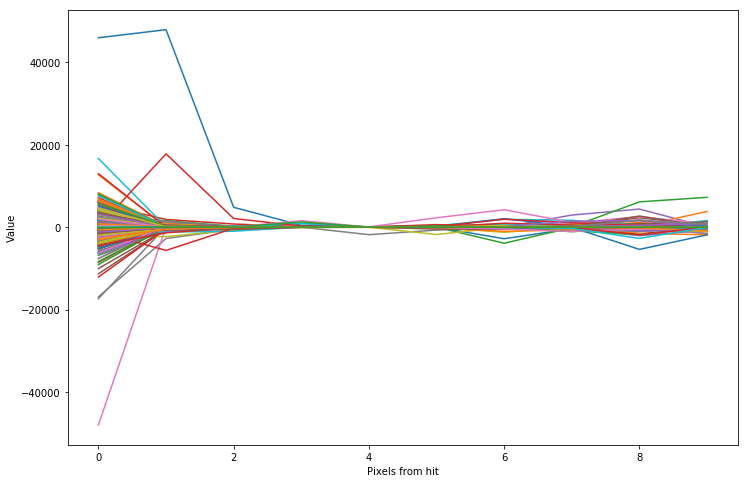

In [47]:
for x in all_tails['R'][1].values():
    plt.plot(x['tails_serial'].T)
plt.xlabel('Pixels from hit')
plt.ylabel('Value')

In [48]:
def nmad(arr):
    med = np.median(arr)
    mad = np.median(np.abs(arr-med))
    return 1.4826 * mad

In [49]:
def fit_cte(channel, amp, serial=False, verbose=False):
    peak_vals = np.concatenate([v['peak_vals'] for k, v in all_tails[channel][amp].items()])
    if serial:
        locs = np.concatenate([v['loc_x'] for k, v in all_tails[channel][amp].items()])
        tail_counts = np.sum(np.concatenate([v['tails_serial'][:, :4] for k, v in all_tails[channel][amp].items()]),
                             axis=1)
    else:
        locs = np.concatenate([v['loc_y'] for k, v in all_tails[channel][amp].items()])
        tail_counts = np.sum(np.concatenate([v['tails_parallel'][:, :4] for k, v in all_tails[channel][amp].items()]),
                             axis=1)

    if serial:
        bins = np.arange(0, 1050, 64)
    else:
        bins = np.arange(0, 5000, 256)
 
    median = np.array([np.median((tail_counts/peak_vals)[np.where((locs>bins[i]) & (locs<bins[i+1]))])
                       for i in range(len(bins)-1)])
    nmads = np.array([nmad((tail_counts/peak_vals)[np.where((locs>bins[i]) & (locs<bins[i+1]))])
                      for i in range(len(bins)-1)])
    cts = np.array([len((tail_counts/peak_vals)[np.where((locs>bins[i]) & (locs<bins[i+1]))])
                    for i in range(len(bins)-1)])
    bins = (bins[1:]+bins[:-1])/2.
    nan_cut = cts==0
    median = median[~nan_cut]
    nmads = nmads[~nan_cut]/cts[~nan_cut]
    bins = bins[~nan_cut]
    
    def chisq(m, b):
        line = m * bins + b
        diff = median - line
        return np.sum(diff**2/nmads**2)
    
    m = Minuit(chisq, pedantic=False, print_level=verbose,
               m=1e-6, b=0,
               limit_m=(-1, 1), limit_b=(-1, 1))
    m.migrad()
    return m.values

def fit_cte_all(channel, amp, serial=False, verbose=False):
    peak_vals = np.concatenate([v['peak_vals'] for k, v in all_tails[channel][amp].items()])
    if serial:
        locs = np.concatenate([v['loc_x'] for k, v in all_tails[channel][amp].items()])
        tail_counts = np.sum(np.concatenate([v['tails_serial'][:, :4] for k, v in all_tails[channel][amp].items()]), axis=1)
    else:
        locs = np.concatenate([v['loc_y'] for k, v in all_tails[channel][amp].items()])
        tail_counts = np.sum(np.concatenate([v['tails_parallel'][:, :4] for k, v in all_tails[channel][amp].items()]), axis=1)

    if serial:
        bins = np.arange(0, 1050, 64)
    else:
        bins = np.arange(0, 5000, 256)
    
    def chisq(m, b):
        line = m * locs + b
        diff = tail_counts/peak_vals - line
        return np.sum(diff**2)
    
    m = Minuit(chisq, pedantic=False, print_level=verbose,
               m=1e-6, b=0,
               limit_m=(-1, 1), limit_b=(-1, 1))
    m.migrad()
    return m.values

In [50]:
def cte_plot(channel, amp, serial=False, all_vals=False):
    peak_vals = np.concatenate([v['peak_vals'] for k, v in all_tails[channel][amp].items()])
    if serial:
        locs = np.concatenate([v['loc_x'] for k, v in all_tails[channel][amp].items()])
        tail_counts = np.sum(np.concatenate([v['tails_serial'] for k, v in all_tails[channel][amp].items()]), axis=1)
    else:
        locs = np.concatenate([v['loc_y'] for k, v in all_tails[channel][amp].items()])
        tail_counts = np.sum(np.concatenate([v['tails_parallel'][:, :4] for k, v in all_tails[channel][amp].items()]), axis=1)
    if all_vals:
        plt.scatter(locs, tail_counts/peak_vals, s=1, alpha=0.2, label='{} channel, amp {}'.format(channel, amp))
    if serial:
        bins = np.arange(0, 1050, 64)
    else:
        bins = np.arange(0, 5000, 256)
    median = [np.median((tail_counts/peak_vals)[np.where((locs>bins[i]) & (locs<bins[i+1]))]) for i in range(len(bins)-1)]
    nmads = np.array([nmad((tail_counts/peak_vals)[np.where((locs>bins[i]) & (locs<bins[i+1]))]) for i in range(len(bins)-1)])
    cts = np.array([len((tail_counts/peak_vals)[np.where((locs>bins[i]) & (locs<bins[i+1]))]) for i in range(len(bins)-1)])
    nmads /= np.sqrt(cts)
    plt.errorbar((bins[1:]+bins[:-1])/2, median,
                 xerr=(bins[1:]-bins[:-1])/2, yerr=nmads,
                 color='C3', linewidth=0, elinewidth=1, marker='.', label='{} channel, amp {}'.format(channel, amp))
    fit = fit_cte(channel, amp, serial)
    plt.plot(bins, fit['m']*bins + fit['b'], color='k')
    plt.legend(loc='upper right')
#     plt.plot(bins, fit_all['m']*bins + fit_all['b'], color='k', alpha=0.3)
    if serial:
        plt.xlim(0, 1028)
    else:
        plt.xlim(0, 4096)
#     plt.ylim(-0.3, 0.3)

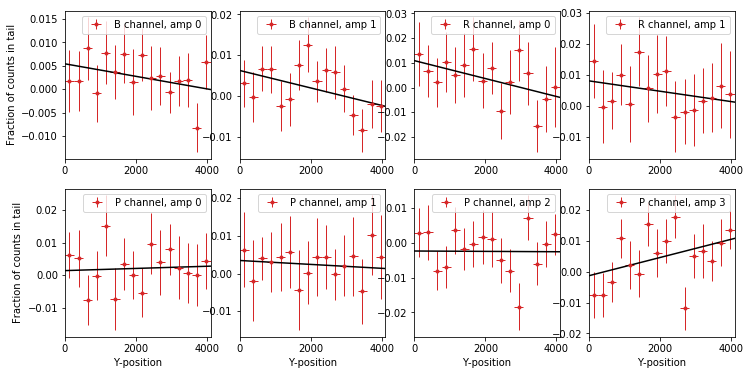

In [51]:
plt.figure(figsize=(12, 6))

plt.subplot(2, 4, 1)
cte_plot('B', 0)
plt.ylabel('Fraction of counts in tail')

plt.subplot(2, 4, 2)
cte_plot('B', 1)

plt.subplot(2, 4, 3)
cte_plot('R', 0)

plt.subplot(2, 4, 4)
cte_plot('R', 1)

plt.subplot(2, 4, 5)
cte_plot('P', 0)
plt.ylabel('Fraction of counts in tail')
plt.xlabel('Y-position')

plt.subplot(2, 4, 6)
cte_plot('P', 1)
plt.xlabel('Y-position')

plt.subplot(2, 4, 7)
cte_plot('P', 2)
plt.xlabel('Y-position')

plt.subplot(2, 4, 8)
cte_plot('P', 3)
plt.xlabel('Y-position')

# plt.savefig('figures/single_night_example_parallel.png', bbox_inches='tight')
plt.savefig('figures/single_night_example_parallel_medians.png', bbox_inches='tight')

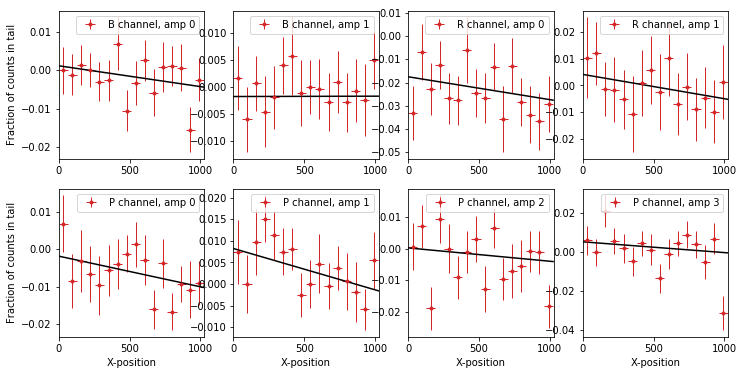

In [52]:
plt.figure(figsize=(12, 6))

plt.subplot(2, 4, 1)
cte_plot('B', 0, True)
plt.ylabel('Fraction of counts in tail')

plt.subplot(2, 4, 2)
cte_plot('B', 1, True)

plt.subplot(2, 4, 3)
cte_plot('R', 0, True)

plt.subplot(2, 4, 4)
cte_plot('R', 1, True)

plt.subplot(2, 4, 5)
cte_plot('P', 0, True)
plt.ylabel('Fraction of counts in tail')
plt.xlabel('X-position')

plt.subplot(2, 4, 6)
cte_plot('P', 1, True)
plt.xlabel('X-position')

plt.subplot(2, 4, 7)
cte_plot('P', 2, True)
plt.xlabel('X-position')

plt.subplot(2, 4, 8)
cte_plot('P', 3, True)
plt.xlabel('X-position')
# plt.savefig('figures/single_night_example_serial.png', bbox_inches='tight')
plt.savefig('figures/single_night_example_serial_medians.png', bbox_inches='tight')

In [53]:
fit_cte('R', 1, False)

{'m': -1.6637041588829504e-06, 'b': 0.008053023957007355}